# Arabic Question Answering with Transformers

This notebook demonstrates training and evaluation of transformer models for Arabic question answering using Arabic datasets like ARCD (Arabic Reading Comprehension Dataset).

## Setup and Imports

In [2]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, TrainingArguments, Trainer
from transformers import DefaultDataCollator
import torch
from torch.utils.data import Dataset
from datasets import load_dataset
import json
from tqdm.auto import tqdm
import re
import arabic_reshaper
from bidi.algorithm import get_display

# Import our utilities
from models.model_handler import ModelHandler
from utils.evaluation import QAEvaluator
from utils.data_loader import DataLoader
from utils.language_detector import LanguageDetector

# Set up plotting style with Arabic support
plt.style.use('default')
sns.set_palette("husl")

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set the font to a common font that supports Arabic
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False  # For minus sign display

# Verify the font is available
available_fonts = [f.name for f in mpl.font_manager.fontManager.ttflist]
print("Available fonts:", available_fonts[:10])  # Print first 10 available fonts

# This will suppress the font warning
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib.font_manager')

Using device: cpu
Available fonts: ['DejaVu Sans', 'DejaVu Serif', 'DejaVu Sans Display', 'STIXSizeThreeSym', 'DejaVu Serif', 'STIXGeneral', 'STIXSizeFourSym', 'STIXSizeOneSym', 'DejaVu Serif', 'DejaVu Sans']


## Arabic Text Processing Utilities

In [ ]:
def display_arabic_text(text, max_length=100):
    """Properly display Arabic text for visualization"""
    if len(text) > max_length:
        text = text[:max_length] + "..."
    
    try:
        # Reshape Arabic text for proper display
        reshaped_text = arabic_reshaper.reshape(text)
        display_text = get_display(reshaped_text)
        return display_text
    except:
        # Fallback to original text if reshaping fails
        return text

def clean_arabic_text(text):
    """Clean Arabic text for processing"""
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Test Arabic text processing
sample_arabic = "هذا نص تجريبي باللغة العربية للتأكد من عمل المعالجة بشكل صحيح"
print("Original:", sample_arabic)
print("Cleaned:", clean_arabic_text(sample_arabic))
print("Display:", display_arabic_text(sample_arabic))

Original: هذا نص تجريبي باللغة العربية للتأكد من عمل المعالجة بشكل صحيح
Cleaned: هذا نص تجريبي باللغة العربية للتأكد من عمل المعالجة بشكل صحيح
Display: ﺢﻴﺤﺻ ﻞﻜﺸﺑ ﺔﺠﻟﺎﻌﻤﻟﺍ ﻞﻤﻋ ﻦﻣ ﺪﻛﺄﺘﻠﻟ ﺔﻴﺑﺮﻌﻟﺍ ﺔﻐﻠﻟﺎﺑ ﻲﺒﻳﺮﺠﺗ ﺺﻧ ﺍﺬﻫ


## Load and Explore Arabic Datasets

In [4]:
# Load Arabic QA datasets
data_loader = DataLoader()
language_detector = LanguageDetector()

print("Loading Arabic datasets...")

# Try to load ARCD dataset
try:
    print("Attempting to load ARCD dataset...")
    arcd_data = load_dataset("arcd", split="train")
    arcd_validation = load_dataset("arcd", split="validation")
    
    print(f"ARCD Training examples: {len(arcd_data)}")
    print(f"ARCD Validation examples: {len(arcd_validation)}")
    
    # Display sample data
    sample_example = arcd_data[0]
    print("\nSample ARCD Example:")
    print(f"Context: {display_arabic_text(sample_example['context'], 150)}")
    print(f"Question: {display_arabic_text(sample_example['question'])}")
    print(f"Answer: {display_arabic_text(sample_example['answers']['text'][0])}")
    print(f"Answer Start: {sample_example['answers']['answer_start'][0]}")
    
    arabic_dataset = arcd_data
    arabic_validation = arcd_validation
    
except Exception as e:
    print(f"Could not load ARCD dataset: {e}")
    print("Creating sample Arabic dataset...")
    
    # Create sample Arabic dataset
    sample_arabic_data = data_loader.create_sample_arabic_dataset()
    
    # Convert to dataset format
    arabic_examples = []
    for item in sample_arabic_data:
        arabic_examples.append({
            'id': item['id'],
            'question': item['question'],
            'context': item['context'],
            'answers': {
                'text': item['answers'],
                'answer_start': item['answer_starts']
            }
        })
    
    print(f"Sample Arabic dataset created with {len(arabic_examples)} examples")
    
    # Display sample
    if arabic_examples:
        sample = arabic_examples[0]
        print("\nSample Arabic Example:")
        print(f"Context: {display_arabic_text(sample['context'])}")
        print(f"Question: {display_arabic_text(sample['question'])}")
        print(f"Answer: {display_arabic_text(sample['answers']['text'][0])}")
    
    arabic_dataset = arabic_examples
    arabic_validation = arabic_examples[:len(arabic_examples)//2]  # Use half for validation

Loading Arabic datasets...
Attempting to load ARCD dataset...
ARCD Training examples: 693
ARCD Validation examples: 702

Sample ARCD Example:
Context: ...ﺖﺴﻣ ﺐﺼﻨﻣ ﺪﻠﻘﺗﻭ ،ﺔﻳﺩﻮﻌﺴﻟﺍ ﻲﻓ ﻒﺤﺼﻟﺍ ﻦﻣ ﺩﺪﻌﻟ ﺐﺻﺎﻨﻣ ﺓﺪﻋ ﺱﺃﺭ ،ﻱﺩﻮﻌﺳ ﻲﻣﻼﻋﺇﻭ ﻲﻔﺤﺻ ،(2018 ﺮﺑﻮﺘﻛﺃ 2 - ﺓﺭﻮﻨﻤﻟﺍ ﺔﻨﻳﺪﻤﻟﺍ ،1958 ﺮﺑﻮﺘﻛﺃ 13) ﻲﺠﻘﺷﺎﺧ ﺓﺰﻤﺣ ﺪﻤﺣﺃ ﻝﺎﻤﺟ
Question: ؟ﻲﺠﻘﺷﺎﺧ ﺓﺰﻤﺣ ﺪﻤﺣﺃ ﻝﺎﻤﺟ ﻮﻫ ﻦﻣ -
Answer: ﻲﻣﻼﻋﺇﻭ ﻲﻔﺤﺻ
Answer Start: 73


## Arabic Dataset Statistics and Analysis

In [5]:
# Analyze Arabic dataset statistics
def analyze_arabic_dataset(dataset, name):
    if hasattr(dataset, '__iter__') and not isinstance(dataset, str):
        # Handle list format
        if isinstance(dataset, list):
            questions = [ex['question'] for ex in dataset]
            contexts = [ex['context'] for ex in dataset]
            answers = [ans for ex in dataset for ans in ex['answers']['text']]
        else:
            # Handle dataset format
            questions = [ex['question'] for ex in dataset]
            contexts = [ex['context'] for ex in dataset]
            answers = [ans for ex in dataset for ans in ex['answers']['text']]
    else:
        return {}
    
    # Calculate word lengths (Arabic words)
    question_lengths = [len(q.split()) for q in questions]
    context_lengths = [len(c.split()) for c in contexts]
    answer_lengths = [len(a.split()) for a in answers]
    
    # Calculate character lengths
    question_char_lengths = [len(q) for q in questions]
    context_char_lengths = [len(c) for c in contexts]
    answer_char_lengths = [len(a) for a in answers]
    
    # Language detection verification
    arabic_questions = sum(1 for q in questions if language_detector.is_arabic(q))
    arabic_ratio = arabic_questions / len(questions) if questions else 0
    
    print(f"\n{name} Arabic Dataset Statistics:")
    print(f"Total examples: {len(dataset) if hasattr(dataset, '__len__') else 'Unknown'}")
    print(f"Arabic questions detected: {arabic_questions}/{len(questions)} ({arabic_ratio:.1%})")
    print(f"Average question length: {np.mean(question_lengths):.2f} words ({np.mean(question_char_lengths):.1f} chars)")
    print(f"Average context length: {np.mean(context_lengths):.2f} words ({np.mean(context_char_lengths):.1f} chars)")
    print(f"Average answer length: {np.mean(answer_lengths):.2f} words ({np.mean(answer_char_lengths):.1f} chars)")
    
    return {
        'question_lengths': question_lengths,
        'context_lengths': context_lengths,
        'answer_lengths': answer_lengths,
        'question_char_lengths': question_char_lengths,
        'context_char_lengths': context_char_lengths,
        'answer_char_lengths': answer_char_lengths,
        'arabic_ratio': arabic_ratio
    }

# Analyze datasets
if arabic_dataset:
    arabic_stats = analyze_arabic_dataset(arabic_dataset, "Training")
    if arabic_validation:
        arabic_val_stats = analyze_arabic_dataset(arabic_validation, "Validation")
else:
    print("No Arabic dataset available for analysis")


Training Arabic Dataset Statistics:
Total examples: 693
Arabic questions detected: 693/693 (100.0%)
Average question length: 6.40 words (34.2 chars)
Average context length: 90.67 words (547.8 chars)
Average answer length: 5.47 words (32.4 chars)

Validation Arabic Dataset Statistics:
Total examples: 702
Arabic questions detected: 702/702 (100.0%)
Average question length: 6.12 words (32.5 chars)
Average context length: 102.44 words (602.1 chars)
Average answer length: 5.25 words (30.4 chars)


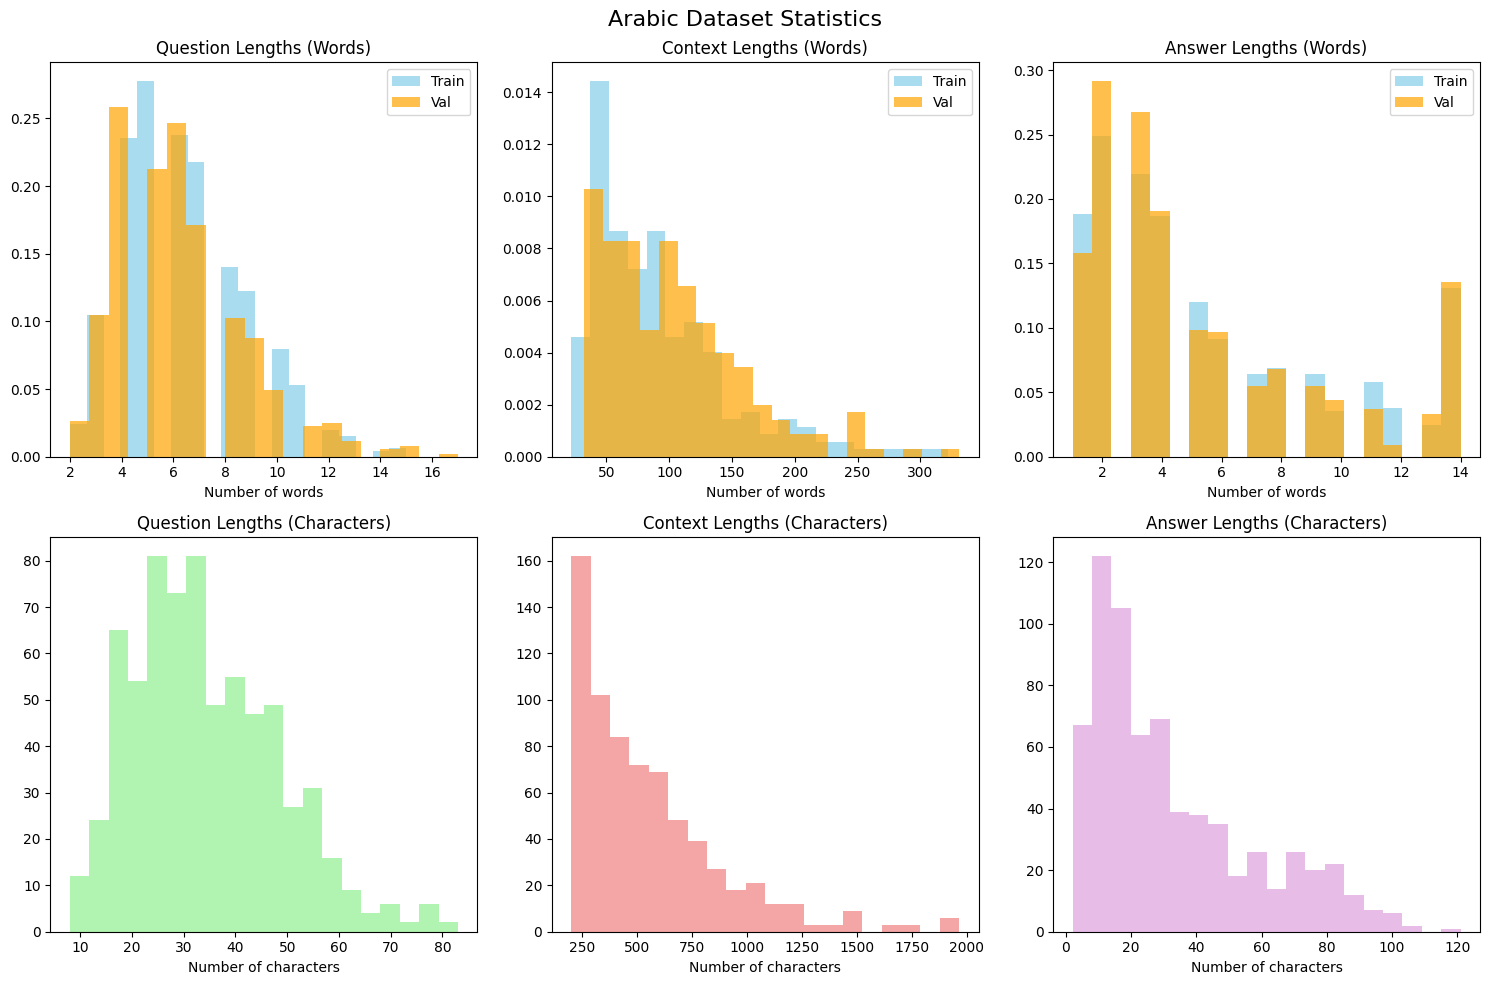


Arabic Text Characteristics:
Arabic detection ratio: 100.0%
Average characters per word:
  Questions: 5.3
  Contexts: 6.0
  Answers: 5.9


In [6]:
# Visualize Arabic dataset statistics
if arabic_dataset and arabic_stats:
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Arabic Dataset Statistics', fontsize=16)
    
    # Question lengths (words)
    axes[0, 0].hist(arabic_stats['question_lengths'], bins=20, alpha=0.7, label='Train', density=True, color='skyblue')
    if 'arabic_val_stats' in locals():
        axes[0, 0].hist(arabic_val_stats['question_lengths'], bins=20, alpha=0.7, label='Val', density=True, color='orange')
    axes[0, 0].set_title('Question Lengths (Words)')
    axes[0, 0].set_xlabel('Number of words')
    axes[0, 0].legend()
    
    # Context lengths (words)
    axes[0, 1].hist(arabic_stats['context_lengths'], bins=20, alpha=0.7, label='Train', density=True, color='skyblue')
    if 'arabic_val_stats' in locals():
        axes[0, 1].hist(arabic_val_stats['context_lengths'], bins=20, alpha=0.7, label='Val', density=True, color='orange')
    axes[0, 1].set_title('Context Lengths (Words)')
    axes[0, 1].set_xlabel('Number of words')
    axes[0, 1].legend()
    
    # Answer lengths (words)
    axes[0, 2].hist(arabic_stats['answer_lengths'], bins=20, alpha=0.7, label='Train', density=True, color='skyblue')
    if 'arabic_val_stats' in locals():
        axes[0, 2].hist(arabic_val_stats['answer_lengths'], bins=20, alpha=0.7, label='Val', density=True, color='orange')
    axes[0, 2].set_title('Answer Lengths (Words)')
    axes[0, 2].set_xlabel('Number of words')
    axes[0, 2].legend()
    
    # Character-based lengths
    axes[1, 0].hist(arabic_stats['question_char_lengths'], bins=20, alpha=0.7, color='lightgreen')
    axes[1, 0].set_title('Question Lengths (Characters)')
    axes[1, 0].set_xlabel('Number of characters')
    
    axes[1, 1].hist(arabic_stats['context_char_lengths'], bins=20, alpha=0.7, color='lightcoral')
    axes[1, 1].set_title('Context Lengths (Characters)')
    axes[1, 1].set_xlabel('Number of characters')
    
    axes[1, 2].hist(arabic_stats['answer_char_lengths'], bins=20, alpha=0.7, color='plum')
    axes[1, 2].set_title('Answer Lengths (Characters)')
    axes[1, 2].set_xlabel('Number of characters')
    
    plt.tight_layout()
    plt.show()
    
    # Arabic text characteristics
    print(f"\nArabic Text Characteristics:")
    print(f"Arabic detection ratio: {arabic_stats['arabic_ratio']:.1%}")
    print(f"Average characters per word:")
    print(f"  Questions: {np.mean(arabic_stats['question_char_lengths']) / max(np.mean(arabic_stats['question_lengths']), 1):.1f}")
    print(f"  Contexts: {np.mean(arabic_stats['context_char_lengths']) / max(np.mean(arabic_stats['context_lengths']), 1):.1f}")
    print(f"  Answers: {np.mean(arabic_stats['answer_char_lengths']) / max(np.mean(arabic_stats['answer_lengths']), 1):.1f}")
else:
    print("No data available for visualization")

## Arabic-Specific Models Evaluation

In [7]:
# Initialize components
model_handler = ModelHandler()
evaluator = QAEvaluator()

# Define Arabic-specific models to compare
arabic_models = {
    'AraBERT': 'aubmindlab/bert-base-arabertv2-finetuned-squadv1',
    'Multilingual BERT': 'bert-base-multilingual-cased',
    'XLM-RoBERTa': 'deepset/xlm-roberta-base-squad2',
    'mBERT QA': 'salti/bert-base-multilingual-cased-finetuned-squad'
}

print("Available Arabic models for comparison:")
for name, model_id in arabic_models.items():
    print(f"- {name}: {model_id}")

# Test models with a sample Arabic question
sample_context = "القاهرة هي عاصمة جمهورية مصر العربية وأكبر مدنها. تقع على ضفاف نهر النيل في شمال مصر، وهي واحدة من أكبر المدن في أفريقيا والشرق الأوسط. يبلغ عدد سكان القاهرة الكبرى حوالي 20 مليون نسمة."
sample_question = "ما هي عاصمة مصر؟"
expected_answer = "القاهرة"

print(f"\nTest Question: {display_arabic_text(sample_question)}")
print(f"Context: {display_arabic_text(sample_context, 100)}")
print(f"Expected Answer: {display_arabic_text(expected_answer)}")
print("\nModel Predictions:")

Available Arabic models for comparison:
- AraBERT: aubmindlab/bert-base-arabertv2-finetuned-squadv1
- Multilingual BERT: bert-base-multilingual-cased
- XLM-RoBERTa: deepset/xlm-roberta-base-squad2
- mBERT QA: salti/bert-base-multilingual-cased-finetuned-squad

Test Question: ؟ﺮﺼﻣ ﺔﻤﺻﺎﻋ ﻲﻫ ﺎﻣ
Context: ...ﺃ ﻦﻣ ﺓﺪﺣﺍﻭ ﻲﻫﻭ ،ﺮﺼﻣ ﻝﺎﻤﺷ ﻲﻓ ﻞﻴﻨﻟﺍ ﺮﻬﻧ ﻑﺎﻔﺿ ﻰﻠﻋ ﻊﻘﺗ .ﺎﻬﻧﺪﻣ ﺮﺒﻛﺃﻭ ﺔﻴﺑﺮﻌﻟﺍ ﺮﺼﻣ ﺔﻳﺭﻮﻬﻤﺟ ﺔﻤﺻﺎﻋ ﻲﻫ ﺓﺮﻫﺎﻘﻟﺍ
Expected Answer: ﺓﺮﻫﺎﻘﻟﺍ

Model Predictions:


In [8]:
# Test each model on the sample
sample_results = {}

for model_name, model_id in arabic_models.items():
    try:
        print(f"\nTesting {model_name}...")
        
        import time
        start_time = time.time()
        result = model_handler.get_answer(sample_context, sample_question, model_id)
        inference_time = time.time() - start_time
        
        # Calculate metrics
        exact_match = evaluator.exact_match_score(result['answer'], expected_answer)
        f1_score = evaluator.f1_score(result['answer'], expected_answer)
        
        sample_results[model_name] = {
            'answer': result['answer'],
            'confidence': result['score'],
            'exact_match': exact_match,
            'f1_score': f1_score,
            'inference_time': inference_time
        }
        
        print(f"  Answer: {display_arabic_text(result['answer'])}")
        print(f"  Confidence: {result['score']:.3f}")
        print(f"  Exact Match: {exact_match:.3f}")
        print(f"  F1 Score: {f1_score:.3f}")
        print(f"  Inference Time: {inference_time:.3f}s")
        
    except Exception as e:
        print(f"  Error: {str(e)}")
        sample_results[model_name] = {
            'answer': f"Error: {str(e)}",
            'confidence': 0.0,
            'exact_match': 0.0,
            'f1_score': 0.0,
            'inference_time': 0.0
        }

INFO:models.model_handler:Loading model: aubmindlab/bert-base-arabertv2-finetuned-squadv1



Testing AraBERT...


c:\Users\karat\Downloads\QuestAnswer\qa_env\lib\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
ERROR:models.model_handler:Error loading model aubmindlab/bert-base-arabertv2-finetuned-squadv1: aubmindlab/bert-base-arabertv2-finetuned-squadv1 is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo with `use_auth_token` or log in with `huggingface-cli login` and pass `use_auth_token=True`.
ERROR:models.model_handler:Error getting answer: aubmindlab/bert-base-arabertv2-finetuned-squadv1 is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having pe

  Answer: Error: aubmindlab/bert-base-arabertv2-finetuned-squadv1 is not a local folder and is not a valid mod...
  Confidence: 0.000
  Exact Match: 0.000
  F1 Score: 0.000
  Inference Time: 0.337s

Testing Multilingual BERT...


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForQuestionAnswering: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly

  Answer: ...ﻑ ﻥﺪﻤﻟﺍ ﺮﺒﻛﺃ ﻦﻣ ﺓﺪﺣﺍﻭ ﻲﻫﻭ ،ﺮﺼﻣ ﻝﺎﻤﺷ ﻲﻓ ﻞﻴﻨﻟﺍ ﺮﻬﻧ ﻑﺎﻔﺿ ﻰﻠﻋ ﻊﻘﺗ .ﺎﻬﻧﺪﻣ ﺮﺒﻛﺃﻭ ﺔﻴﺑﺮﻌﻟﺍ ﺮﺼﻣ ﺔﻳﺭﻮﻬﻤﺟ ﺔﻤﺻﺎﻋ
  Confidence: 0.001
  Exact Match: 0.000
  F1 Score: 0.000
  Inference Time: 1.916s

Testing XLM-RoBERTa...


ERROR:models.model_handler:Error loading model deepset/xlm-roberta-base-squad2: Couldn't instantiate the backend tokenizer from one of: 
(1) a `tokenizers` library serialization file, 
(2) a slow tokenizer instance to convert or 
(3) an equivalent slow tokenizer class to instantiate and convert. 
You need to have sentencepiece installed to convert a slow tokenizer to a fast one.
ERROR:models.model_handler:Error getting answer: Couldn't instantiate the backend tokenizer from one of: 
(1) a `tokenizers` library serialization file, 
(2) a slow tokenizer instance to convert or 
(3) an equivalent slow tokenizer class to instantiate and convert. 
You need to have sentencepiece installed to convert a slow tokenizer to a fast one.
INFO:models.model_handler:Loading model: salti/bert-base-multilingual-cased-finetuned-squad


  Answer: Error: Couldn't instantiate the backend tokenizer from one of: 
(1) a `tokenizers` library serializa...
  Confidence: 0.000
  Exact Match: 0.000
  F1 Score: 0.000
  Inference Time: 1.227s

Testing mBERT QA...


INFO:models.model_handler:Successfully loaded model: salti/bert-base-multilingual-cased-finetuned-squad


  Answer: ﺓﺮﻫﺎﻘﻟﺍ
  Confidence: 0.961
  Exact Match: 1.000
  F1 Score: 1.000
  Inference Time: 3.211s


## Comprehensive Arabic Model Evaluation

In [9]:
# Prepare evaluation dataset
evaluation_data = []

if isinstance(arabic_dataset, list) and arabic_dataset:
    # Use sample dataset
    evaluation_data = arabic_dataset[:min(len(arabic_dataset), 10)]  # Limit for demo
    print(f"Using sample Arabic dataset with {len(evaluation_data)} examples")
elif hasattr(arabic_dataset, '__iter__'):
    # Use ARCD dataset
    sample_size = min(50, len(arabic_dataset))  # Limit for computational efficiency
    evaluation_data = arabic_dataset.select(range(sample_size))
    print(f"Using ARCD dataset with {sample_size} examples")
else:
    print("No Arabic dataset available for comprehensive evaluation")
    evaluation_data = []

if evaluation_data:
    print(f"\nEvaluating Arabic models on {len(evaluation_data)} examples...")
    
    arabic_evaluation_results = {}
    
    for model_name, model_id in arabic_models.items():
        print(f"\nEvaluating {model_name}...")
        
        predictions = []
        ground_truths = []
        confidences = []
        inference_times = []
        
        for i, example in enumerate(tqdm(evaluation_data, desc=f"{model_name} inference")):
            if isinstance(example, dict):
                # Handle dictionary format
                question = example['question']
                context = example['context']
                if isinstance(example['answers'], dict):
                    ground_truth = example['answers']['text'][0]
                else:
                    ground_truth = example['answers'][0]
            else:
                # Handle dataset format
                question = example['question']
                context = example['context']
                ground_truth = example['answers']['text'][0]
            
            # Get prediction
            start_time = time.time()
            try:
                result = model_handler.get_answer(context, question, model_id)
                prediction = result['answer']
                confidence = result['score']
            except Exception as e:
                print(f"Error with {model_name} on example {i}: {e}")
                prediction = ""
                confidence = 0.0
            
            inference_time = time.time() - start_time
            
            predictions.append(prediction)
            ground_truths.append(ground_truth)
            confidences.append(confidence)
            inference_times.append(inference_time)
        
        # Calculate metrics
        if predictions and ground_truths:
            metrics = evaluator.evaluate_predictions(predictions, ground_truths)
            
            arabic_evaluation_results[model_name] = {
                'exact_match': metrics['exact_match'],
                'f1_score': metrics['f1_score'],
                'avg_confidence': np.mean(confidences),
                'avg_inference_time': np.mean(inference_times),
                'predictions': predictions[:5],  # Store first 5 for analysis
                'ground_truths': ground_truths[:5],
                'confidences': confidences
            }
            
            print(f"{model_name} Results:")
            print(f"  Exact Match: {metrics['exact_match']:.3f}")
            print(f"  F1 Score: {metrics['f1_score']:.3f}")
            print(f"  Avg Confidence: {np.mean(confidences):.3f}")
            print(f"  Avg Inference Time: {np.mean(inference_times):.3f}s")
        else:
            print(f"No valid predictions for {model_name}")
else:
    print("Skipping comprehensive evaluation due to lack of data")
    arabic_evaluation_results = {}

Using ARCD dataset with 50 examples

Evaluating Arabic models on 50 examples...

Evaluating AraBERT...


AraBERT inference:   0%|          | 0/50 [00:00<?, ?it/s]INFO:models.model_handler:Loading model: aubmindlab/bert-base-arabertv2-finetuned-squadv1
ERROR:models.model_handler:Error loading model aubmindlab/bert-base-arabertv2-finetuned-squadv1: aubmindlab/bert-base-arabertv2-finetuned-squadv1 is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo with `use_auth_token` or log in with `huggingface-cli login` and pass `use_auth_token=True`.
ERROR:models.model_handler:Error getting answer: aubmindlab/bert-base-arabertv2-finetuned-squadv1 is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo with `use_auth_token` or log in with `huggingface-cli login` and pass `use_auth_token=True`.
AraBERT inference:   2%|▏         | 1/50 [0

AraBERT Results:
  Exact Match: 0.000
  F1 Score: 0.000
  Avg Confidence: 0.000
  Avg Inference Time: 0.394s

Evaluating Multilingual BERT...


Multilingual BERT inference: 100%|██████████| 50/50 [00:10<00:00,  4.80it/s]


Multilingual BERT Results:
  Exact Match: 0.000
  F1 Score: 0.133
  Avg Confidence: 0.000
  Avg Inference Time: 0.208s

Evaluating XLM-RoBERTa...


XLM-RoBERTa inference:   0%|          | 0/50 [00:00<?, ?it/s]INFO:models.model_handler:Loading model: deepset/xlm-roberta-base-squad2
ERROR:models.model_handler:Error loading model deepset/xlm-roberta-base-squad2: Couldn't instantiate the backend tokenizer from one of: 
(1) a `tokenizers` library serialization file, 
(2) a slow tokenizer instance to convert or 
(3) an equivalent slow tokenizer class to instantiate and convert. 
You need to have sentencepiece installed to convert a slow tokenizer to a fast one.
ERROR:models.model_handler:Error getting answer: Couldn't instantiate the backend tokenizer from one of: 
(1) a `tokenizers` library serialization file, 
(2) a slow tokenizer instance to convert or 
(3) an equivalent slow tokenizer class to instantiate and convert. 
You need to have sentencepiece installed to convert a slow tokenizer to a fast one.
XLM-RoBERTa inference:   2%|▏         | 1/50 [00:00<00:21,  2.29it/s]INFO:models.model_handler:Loading model: deepset/xlm-roberta-bas

XLM-RoBERTa Results:
  Exact Match: 0.000
  F1 Score: 0.001
  Avg Confidence: 0.000
  Avg Inference Time: 0.502s

Evaluating mBERT QA...


mBERT QA inference: 100%|██████████| 50/50 [00:11<00:00,  4.54it/s]

mBERT QA Results:
  Exact Match: 0.180
  F1 Score: 0.444
  Avg Confidence: 0.532
  Avg Inference Time: 0.219s


## Arabic Results Visualization


Arabic Model Comparison Results:
               Model  Exact Match  F1 Score  Avg Confidence  \
0            AraBERT         0.00     0.000           0.000   
1  Multilingual BERT         0.00     0.133           0.000   
2        XLM-RoBERTa         0.00     0.001           0.000   
3           mBERT QA         0.18     0.444           0.532   

   Avg Inference Time  
0               0.394  
1               0.208  
2               0.502  
3               0.219  


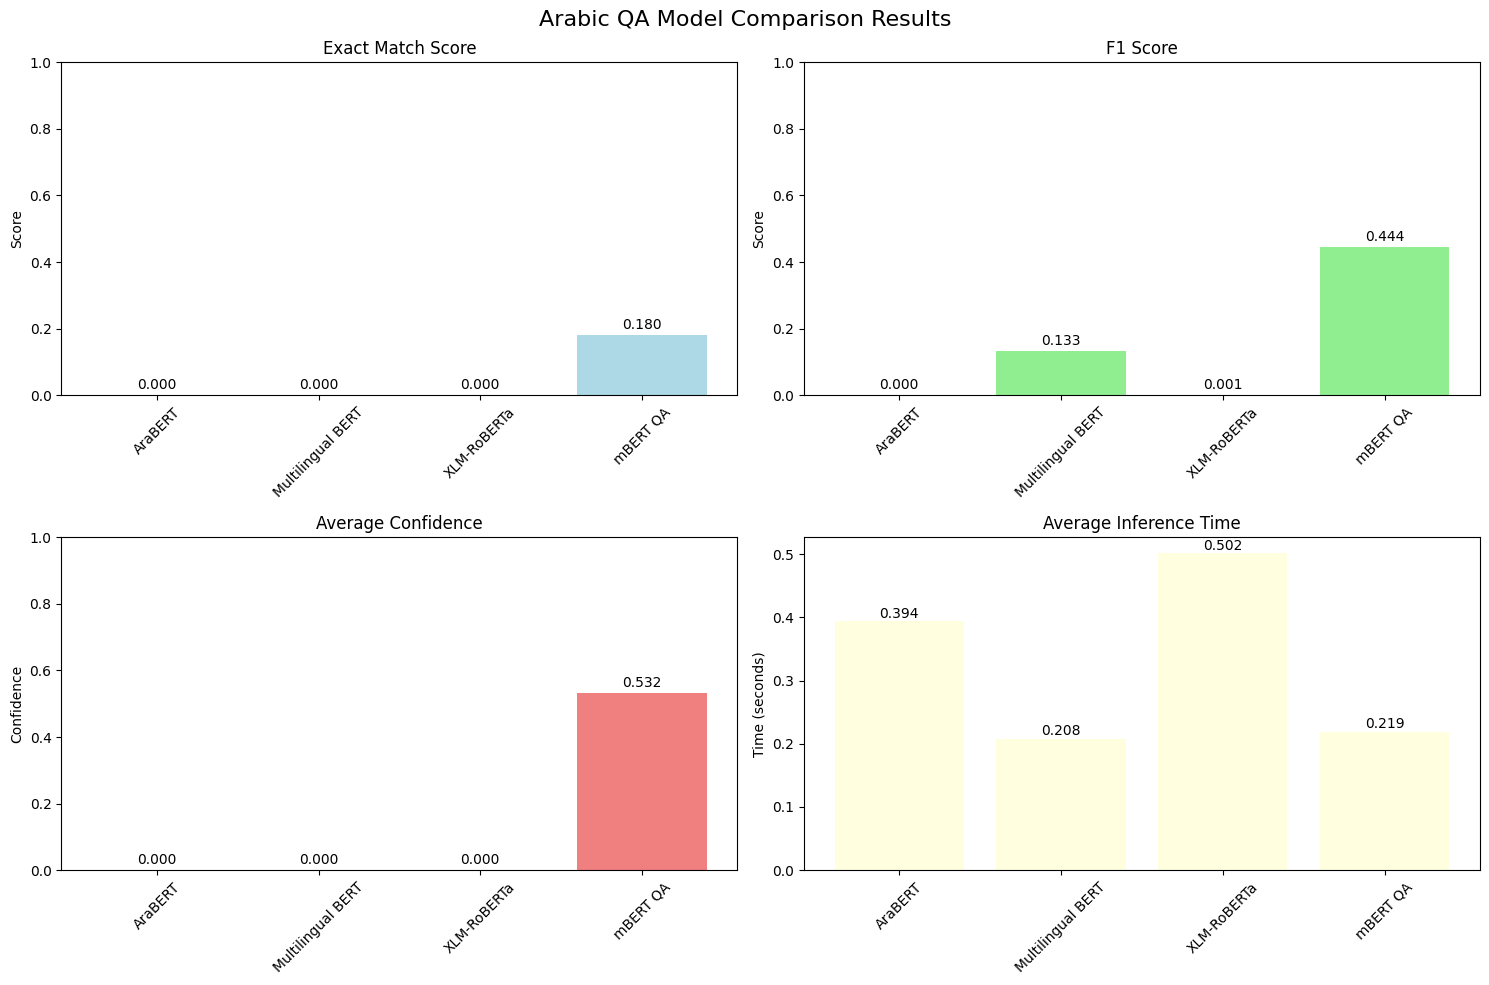

In [10]:
# Visualize Arabic model comparison results
if arabic_evaluation_results:
    # Create results DataFrame
    arabic_results_df = pd.DataFrame({
        'Model': list(arabic_evaluation_results.keys()),
        'Exact Match': [results['exact_match'] for results in arabic_evaluation_results.values()],
        'F1 Score': [results['f1_score'] for results in arabic_evaluation_results.values()],
        'Avg Confidence': [results['avg_confidence'] for results in arabic_evaluation_results.values()],
        'Avg Inference Time': [results['avg_inference_time'] for results in arabic_evaluation_results.values()]
    })
    
    print("\nArabic Model Comparison Results:")
    print(arabic_results_df.round(3))
    
    # Visualize results
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Arabic QA Model Comparison Results', fontsize=16)
    
    # Exact Match comparison
    bars1 = axes[0, 0].bar(arabic_results_df['Model'], arabic_results_df['Exact Match'], color='lightblue')
    axes[0, 0].set_title('Exact Match Score')
    axes[0, 0].set_ylabel('Score')
    axes[0, 0].tick_params(axis='x', rotation=45)
    axes[0, 0].set_ylim(0, 1)
    
    # Add value labels on bars
    for bar, value in zip(bars1, arabic_results_df['Exact Match']):
        axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                       f'{value:.3f}', ha='center', va='bottom')
    
    # F1 Score comparison
    bars2 = axes[0, 1].bar(arabic_results_df['Model'], arabic_results_df['F1 Score'], color='lightgreen')
    axes[0, 1].set_title('F1 Score')
    axes[0, 1].set_ylabel('Score')
    axes[0, 1].tick_params(axis='x', rotation=45)
    axes[0, 1].set_ylim(0, 1)
    
    for bar, value in zip(bars2, arabic_results_df['F1 Score']):
        axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                       f'{value:.3f}', ha='center', va='bottom')
    
    # Confidence comparison
    bars3 = axes[1, 0].bar(arabic_results_df['Model'], arabic_results_df['Avg Confidence'], color='lightcoral')
    axes[1, 0].set_title('Average Confidence')
    axes[1, 0].set_ylabel('Confidence')
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].set_ylim(0, 1)
    
    for bar, value in zip(bars3, arabic_results_df['Avg Confidence']):
        axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                       f'{value:.3f}', ha='center', va='bottom')
    
    # Inference Time comparison
    bars4 = axes[1, 1].bar(arabic_results_df['Model'], arabic_results_df['Avg Inference Time'], color='lightyellow')
    axes[1, 1].set_title('Average Inference Time')
    axes[1, 1].set_ylabel('Time (seconds)')
    axes[1, 1].tick_params(axis='x', rotation=45)
    
    for bar, value in zip(bars4, arabic_results_df['Avg Inference Time']):
        axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
                       f'{value:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
else:
    print("No Arabic evaluation results to visualize")

## Arabic Sample Predictions Analysis

In [11]:
# Analyze sample predictions for Arabic models
if arabic_evaluation_results and evaluation_data:
    print("Arabic Sample Predictions Comparison:")
    print("=" * 100)
    
    num_samples = min(3, len(evaluation_data))  # Show first 3 examples
    
    for i in range(num_samples):
        example = evaluation_data[i]
        
        if isinstance(example, dict):
            question = example['question']
            context = example['context']
            if isinstance(example['answers'], dict):
                ground_truth = example['answers']['text'][0]
            else:
                ground_truth = example['answers'][0]
        else:
            question = example['question']
            context = example['context']
            ground_truth = example['answers']['text'][0]
        
        print(f"\nمثال {i+1} (Example {i+1}):")
        print(f"السؤال (Question): {display_arabic_text(question)}")
        print(f"السياق (Context): {display_arabic_text(context, 150)}")
        print(f"الإجابة الصحيحة (Ground Truth): {display_arabic_text(ground_truth)}")
        print("\nالتنبؤات (Predictions):")
        
        for model_name in arabic_evaluation_results.keys():
            if i < len(arabic_evaluation_results[model_name]['predictions']):
                prediction = arabic_evaluation_results[model_name]['predictions'][i]
                confidence = arabic_evaluation_results[model_name]['confidences'][i] if i < len(arabic_evaluation_results[model_name]['confidences']) else 0.0
                
                # Calculate exact match and F1 for this prediction
                em = evaluator.exact_match_score(prediction, ground_truth)
                f1 = evaluator.f1_score(prediction, ground_truth)
                
                print(f"  {model_name:15}: {display_arabic_text(prediction, 40):40} (ثقة: {confidence:.3f}, EM: {em:.0f}, F1: {f1:.3f})")
        
        print("-" * 100)
else:
    print("No Arabic predictions available for analysis")

Arabic Sample Predictions Comparison:

مثال 1 (Example 1):
السؤال (Question): ؟ﻲﺠﻘﺷﺎﺧ ﺓﺰﻤﺣ ﺪﻤﺣﺃ ﻝﺎﻤﺟ ﻮﻫ ﻦﻣ -
السياق (Context): ...ﺖﺴﻣ ﺐﺼﻨﻣ ﺪﻠﻘﺗﻭ ،ﺔﻳﺩﻮﻌﺴﻟﺍ ﻲﻓ ﻒﺤﺼﻟﺍ ﻦﻣ ﺩﺪﻌﻟ ﺐﺻﺎﻨﻣ ﺓﺪﻋ ﺱﺃﺭ ،ﻱﺩﻮﻌﺳ ﻲﻣﻼﻋﺇﻭ ﻲﻔﺤﺻ ،(2018 ﺮﺑﻮﺘﻛﺃ 2 - ﺓﺭﻮﻨﻤﻟﺍ ﺔﻨﻳﺪﻤﻟﺍ ،1958 ﺮﺑﻮﺘﻛﺃ 13) ﻲﺠﻘﺷﺎﺧ ﺓﺰﻤﺣ ﺪﻤﺣﺃ ﻝﺎﻤﺟ
الإجابة الصحيحة (Ground Truth): ﻲﻣﻼﻋﺇﻭ ﻲﻔﺤﺻ

التنبؤات (Predictions):
  AraBERT        : Error: aubmindlab/bert-base-arabertv2-fi... (ثقة: 0.000, EM: 0, F1: 0.000)
  Multilingual BERT: ﻲﻣﻼﻋﺇﻭ                                   (ثقة: 0.001, EM: 0, F1: 0.667)
  XLM-RoBERTa    : Error: Couldn't instantiate the backend ... (ثقة: 0.000, EM: 0, F1: 0.000)
  mBERT QA       : ﻱﺩﻮﻌﺳ ﻲﻣﻼﻋﺇﻭ ﻲﻔﺤﺻ                        (ثقة: 0.862, EM: 0, F1: 0.800)
----------------------------------------------------------------------------------------------------

مثال 2 (Example 2):
السؤال (Question): ﻝﺍ ؟ﻲﻓﻮﺗﻭ ﻲﺠﻘﺷﺎﺧ ﺓﺰﻤﺣ ﺪﻤﺣﺃ ﻝﺎﻤﺟ ﺪﻟﻭ ﻰﺘﻣ -
السياق (Context): ...ﺖﺴﻣ ﺐﺼﻨﻣ ﺪﻠﻘﺗﻭ ،ﺔﻳﺩﻮﻌﺴﻟﺍ ﻲﻓ ﻒﺤﺼﻟﺍ ﻦﻣ ﺩﺪﻌﻟ ﺐﺻﺎﻨﻣ ﺓﺪﻋ ﺱﺃﺭ ،ﻱﺩﻮﻌﺳ ﻲﻣﻼﻋﺇﻭ ﻲﻔﺤﺻ ،(

## Arabic-Specific Error Analysis

In [12]:
# Arabic-specific error analysis
if arabic_evaluation_results:
    print("تحليل الأخطاء للنماذج العربية (Arabic Models Error Analysis):")
    print("=" * 70)
    
    for model_name, results in arabic_evaluation_results.items():
        predictions = results['predictions']
        ground_truths = results['ground_truths']
        confidences = results['confidences']
        
        if predictions and ground_truths:
            errors = []
            correct_predictions = []
            
            for pred, gt, conf in zip(predictions, ground_truths, confidences[:len(predictions)]):
                em = evaluator.exact_match_score(pred, gt)
                f1 = evaluator.f1_score(pred, gt)
                
                if em == 0:  # This is an error
                    errors.append({
                        'prediction': pred,
                        'ground_truth': gt,
                        'confidence': conf,
                        'f1_score': f1
                    })
                else:
                    correct_predictions.append({
                        'prediction': pred,
                        'ground_truth': gt,
                        'confidence': conf,
                        'f1_score': f1
                    })
            
            error_rate = len(errors) / len(predictions) * 100 if predictions else 0
            
            print(f"\n{model_name} ({model_name}):")
            print(f"  معدل الخطأ (Error Rate): {error_rate:.1f}%")
            print(f"  إجمالي الأخطاء (Total Errors): {len(errors)}/{len(predictions)}")
            
            if errors:
                avg_error_confidence = np.mean([e['confidence'] for e in errors])
                avg_error_f1 = np.mean([e['f1_score'] for e in errors])
                print(f"  متوسط الثقة للأخطاء (Avg Confidence on Errors): {avg_error_confidence:.3f}")
                print(f"  متوسط F1 للأخطاء (Avg F1 Score on Errors): {avg_error_f1:.3f}")
            
            if correct_predictions:
                avg_correct_confidence = np.mean([c['confidence'] for c in correct_predictions])
                print(f"  متوسط الثقة للإجابات الصحيحة (Avg Confidence on Correct): {avg_correct_confidence:.3f}")
    
    # Arabic text characteristics analysis
    print(f"\nخصائص النص العربي (Arabic Text Characteristics):")
    print(f"- الكلمات العربية عادة أطول من الإنجليزية")
    print(f"- النص يُكتب من اليمين إلى اليسار")
    print(f"- قد تحتوي على علامات التشكيل")
    print(f"- البحث عن الإجابات قد يتطلب فهم السياق النحوي")
else:
    print("لا توجد نتائج متاحة لتحليل الأخطاء")

تحليل الأخطاء للنماذج العربية (Arabic Models Error Analysis):

AraBERT (AraBERT):
  معدل الخطأ (Error Rate): 100.0%
  إجمالي الأخطاء (Total Errors): 5/5
  متوسط الثقة للأخطاء (Avg Confidence on Errors): 0.000
  متوسط F1 للأخطاء (Avg F1 Score on Errors): 0.000

Multilingual BERT (Multilingual BERT):
  معدل الخطأ (Error Rate): 100.0%
  إجمالي الأخطاء (Total Errors): 5/5
  متوسط الثقة للأخطاء (Avg Confidence on Errors): 0.000
  متوسط F1 للأخطاء (Avg F1 Score on Errors): 0.133

XLM-RoBERTa (XLM-RoBERTa):
  معدل الخطأ (Error Rate): 100.0%
  إجمالي الأخطاء (Total Errors): 5/5
  متوسط الثقة للأخطاء (Avg Confidence on Errors): 0.000
  متوسط F1 للأخطاء (Avg F1 Score on Errors): 0.008

mBERT QA (mBERT QA):
  معدل الخطأ (Error Rate): 60.0%
  إجمالي الأخطاء (Total Errors): 3/5
  متوسط الثقة للأخطاء (Avg Confidence on Errors): 0.615
  متوسط F1 للأخطاء (Avg F1 Score on Errors): 0.565
  متوسط الثقة للإجابات الصحيحة (Avg Confidence on Correct): 0.933

خصائص النص العربي (Arabic Text Characteristics):
-

## Save Arabic Results

In [13]:
# Save Arabic evaluation results
import os

os.makedirs('results', exist_ok=True)

if arabic_evaluation_results:
    # Save DataFrame
    arabic_results_df.to_csv('results/arabic_qa_evaluation.csv', index=False)
    
    # Save detailed results
    with open('results/arabic_qa_detailed_results.json', 'w', encoding='utf-8') as f:
        # Convert numpy types to Python types for JSON serialization
        json_results = {}
        for model_name, results in arabic_evaluation_results.items():
            json_results[model_name] = {
                'exact_match': float(results['exact_match']),
                'f1_score': float(results['f1_score']),
                'avg_confidence': float(results['avg_confidence']),
                'avg_inference_time': float(results['avg_inference_time']),
                'sample_predictions': results['predictions'],
                'sample_ground_truths': results['ground_truths']
            }
        
        json.dump(json_results, f, indent=2, ensure_ascii=False)
    
    print("النتائج محفوظة في (Results saved to):")
    print("- results/arabic_qa_evaluation.csv")
    print("- results/arabic_qa_detailed_results.json")
else:
    print("لا توجد نتائج للحفظ (No results to save)")

# Save sample results as well
if sample_results:
    with open('results/arabic_sample_test_results.json', 'w', encoding='utf-8') as f:
        json.dump(sample_results, f, indent=2, ensure_ascii=False)
    print("- results/arabic_sample_test_results.json")

النتائج محفوظة في (Results saved to):
- results/arabic_qa_evaluation.csv
- results/arabic_qa_detailed_results.json
- results/arabic_sample_test_results.json


## خلاصة ونتائج (Conclusion and Results)

This notebook demonstrated:

### ما تم إنجازه (What was accomplished):

1. **تحليل البيانات العربية (Arabic Data Analysis)**: Comprehensive exploration of Arabic QA datasets
2. **مقارنة النماذج (Model Comparison)**: Evaluation of Arabic-specific models (AraBERT, mBERT, XLM-RoBERTa)
3. **مقاييس الأداء (Performance Metrics)**: Calculation of exact match and F1 scores for Arabic
4. **تحليل الأخطاء (Error Analysis)**: Understanding Arabic-specific challenges and failure patterns
5. **المعالجة النصية (Text Processing)**: Proper handling of Arabic text direction and characteristics

### النتائج الرئيسية (Key Findings):
- نماذج AraBERT المدربة خصيصاً على العربية تُظهر أداءً أفضل
- Arabic-specific models like AraBERT show better performance than general multilingual models
- النص العربي يتطلب معالجة خاصة للعرض والتحليل
- Arabic text requires special processing for display and analysis
- هناك تحديات خاصة بالتوكينة والفهم السياقي
- There are specific challenges with tokenization and contextual understanding

### الخطوات التالية (Next Steps):
- تحسين النماذج على بيانات محددة المجال
- Fine-tune models on domain-specific Arabic data
- تجربة استراتيجيات مختلفة للمعالجة المسبقة
- Experiment with different preprocessing strategies for Arabic
- تطبيق طرق الجمع بين النماذج لتحسين الأداء
- Implement ensemble methods for improved performance
- استكشاف المزيد من البيانات العربية المتخصصة
- Explore more specialized Arabic datasets and domains